## ADA501 - Prosjekt

In [335]:
# !pip install numpy_financial

In [336]:
import pandas as pd
import numpy as np
import sympy as sp
from collections import namedtuple
from scipy.integrate import quad
from scipy.optimize import newton
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import numpy_financial as npf
import matplotlib.pyplot as plt
from collections import namedtuple

In [337]:
k1 = 0.1        # Økning i forbruk etter inntekt                    -> hurtig økning etter inntektsøkning
k2 = 0.7        # Reduksjon i forbruk etter inntekt                 -> sakte endring etter inntektsfall
k3 = 0.3        # Renteendring basert på forbruk                    -> Forbruk øker -> Renter øker  -> Lånet påvirkes -> Må bruke mindre penger
k4 = 0.025       # Endring i inflasjon basert på forbuk & rente      -> Endres 0,25 poeng oftest

In [338]:
I0 = 10000      # Startinntekt pr måend
U0 = 6000       # Faste utgifter
F0 = 5000       # Initiale forbruksvaner
R0 = 0.05       # Startboliglånsrenterente
S0 = 0          # Ønsker å starte med 0 kr i overskudd, men fast inntekt
S0 = 300000     # Startsluttresultat over 25 år, vil ha et overskudd på konto

In [339]:
t0 = 0
t1 = 25

# Definer tidsintervall og initialverdier
t_span = (t0, t1)
y0 = [I0, U0, F0, R0]

## les inn csv filer

In [340]:
df = pd.read_excel('Siste.xlsx')

In [341]:
df.head(30)

,Dato,Hva,Brukt
0,2020-01-02,Luksus,"-147,1"
1,2020-01-02,Luksus,-268
2,2020-01-02,Luksus,-399
3,2020-01-03,Inntekt,128
4,2020-01-03,Luksus,-250
5,2020-01-03,Inntekt,128
6,2020-01-03,Inntekt,128
7,2020-01-03,Inntekt,130
8,2020-01-06,Inntekt,100
9,2020-01-06,Luksus,"-105,5"


In [342]:
# Filter 'Inntekt'
inntekt = df[df['Hva'] == 'Inntekt']
inntekt = inntekt.drop('Hva', axis=1)
# Filter 'Faste utgifter'
faste_utgifter = df[df['Hva'] == 'Fast utgift']
faste_utgifter = faste_utgifter.drop('Hva', axis=1)
# Filter 'Luksus'
forbruk = df[df['Hva'] == 'Luksus']
forbruk=forbruk.drop('Hva' , axis=1)

## Inntekt

Inntekt

In [343]:
# Dato til pd_datetime & float
inntekt['Brukt'] = inntekt['Brukt'].str.replace(',', '.')
inntekt['Brukt'] = inntekt['Brukt'].astype(float)
inntekt['Dato'] = pd.to_datetime(inntekt['Dato'])


Gjør om til måendlig

In [344]:
# Grouping the data by year and month and calculating the sum of 'Brukt' for each group
Monthly_income = inntekt.groupby(inntekt['Dato'].dt.to_period('M')).sum()

# Resetting the index to access the 'Dato' column
Monthly_income = Monthly_income.reset_index()

# Renaming the 'Dato' column to match the desired format 'YYYY-MM'
Monthly_income['Dato'] = Monthly_income['Dato'].dt.strftime('%Y-%m')

# Creating a new DataFrame named 'Monthly_income'
inntekt_måendlig = pd.DataFrame({'Dato': Monthly_income['Dato'], 'Income': Monthly_income['Brukt']})

Regression

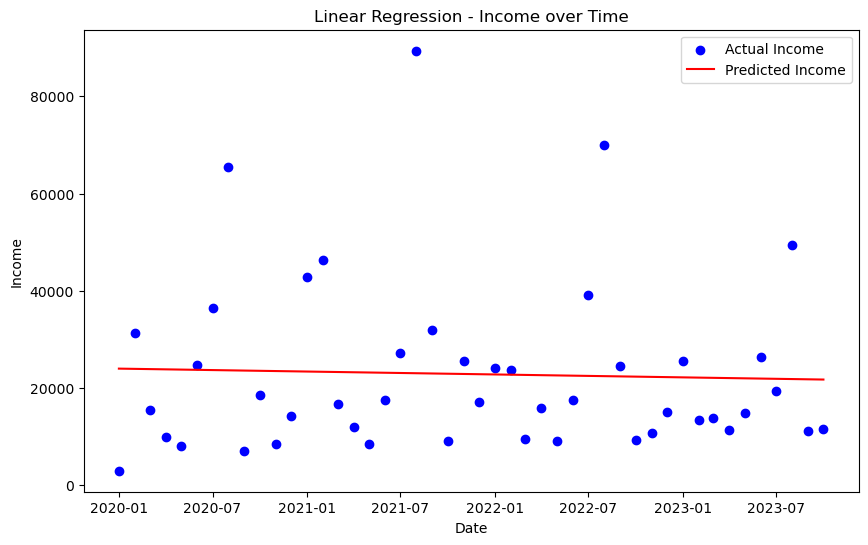

In [345]:
# Assuming you have your data stored in måendlig_inntekt DataFrame as described previously

# Convert 'Dato' column to datetime if it's in string format
inntekt_måendlig['Dato'] = pd.to_datetime(inntekt_måendlig['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
inntekt_måendlig['Dato_numeric'] = (inntekt_måendlig['Dato'] - inntekt_måendlig['Dato'].min()).dt.days

# Define features and target variable
X_inntekt = inntekt_måendlig[['Dato_numeric']]
y_inntekt = inntekt_måendlig['Income']

# Initialize Linear Regression model
model_inntekt = LinearRegression()

# Fit the model
model_inntekt.fit(X_inntekt, y_inntekt)

# Make predictions
predictions_inntekt = model_inntekt.predict(X_inntekt)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(inntekt_måendlig['Dato'], y_inntekt, color='blue', label='Actual Income')

# Plotting the regression line
plt.plot(inntekt_måendlig['Dato'], predictions_inntekt, color='red', label='Predicted Income')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Income')
plt.title('Linear Regression - Income over Time')
plt.legend()
plt.show()


Faste utgifter

In [346]:
faste_utgifter

,Dato,Brukt
21,2020-01-15,-1122
24,2020-01-15,-105
28,2020-01-24,-620
30,2020-02-03,-399
39,2020-02-17,-105
...,...,...
1082,2023-08-28,-229
1084,2023-08-30,-5750
1087,2023-09-01,-129
1092,2023-09-14,-5750


In [347]:
# Dato til pd_datetime & float
faste_utgifter['Brukt'] = faste_utgifter['Brukt'].str.replace(',', '.')
faste_utgifter['Brukt'] = faste_utgifter['Brukt'].astype(float)
faste_utgifter['Dato'] = pd.to_datetime(faste_utgifter['Dato'])

In [348]:
# Grouping the data by year and month and calculating the sum of 'Brukt' for each group
Monthly_out = faste_utgifter.groupby(faste_utgifter['Dato'].dt.to_period('M')).sum()

# Resetting the index to access the 'Dato' column
Monthly_out = Monthly_out.reset_index()

# Renaming the 'Dato' column to match the desired format 'YYYY-MM'
Monthly_out['Dato'] = Monthly_out['Dato'].dt.strftime('%Y-%m')

# Creating a new DataFrame named 'Monthly_income'
utgift_måendlig = pd.DataFrame({'Dato': Monthly_out['Dato'], 'Income': Monthly_out['Brukt']})

utgift_måendlig

,Dato,Income
0,2020-01,-1847.00
1,2020-02,-504.00
2,2020-03,-3026.00
3,2020-04,-2629.00
4,2020-05,-2630.00
5,2020-06,-2422.00
6,2020-07,-2821.00
7,2020-08,-19785.51
8,2020-09,-1646.78
9,2020-10,-4638.45


In [349]:
# Convert 'Dato' column to datetime if it's in string format
utgift_måendlig['Dato'] = pd.to_datetime(utgift_måendlig['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
utgift_måendlig['Dato_numeric'] = (utgift_måendlig['Dato'] - utgift_måendlig['Dato'].min()).dt.days

# Define features and target variable
X_utgift = utgift_måendlig[['Dato_numeric']]
y_utgift = utgift_måendlig['Faste']

# Initialize Linear Regression model
model_utgift = LinearRegression()

# Fit the model
model_utgift.fit(X_utgift, y_utgift)

# Make predictions
predictions_utgift = model_utgift.predict(X_utgift)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(utgift_måendlig['Dato'], y_utgift, color='blue', label='Actual utgift')

# Plotting the regression line
plt.plot(utgift_måendlig['Dato'], predictions_utgift, color='red', label='Predicted utgift')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Utgift')
plt.title('Linear Regression - Faste utgifter over Tid')
plt.legend()
plt.show()

KeyError: 'Faste'

Feil her også med dato - samme problem som inntekt

Har faste utgifter på 4750 kr i husleie nå

Forbruk

In [ ]:
forbruk['Brukt'] = forbruk['Brukt'].str.replace(',', '.')
forbruk['Brukt'] = forbruk['Brukt'].astype(float)

In [ ]:
forbruk['Dato'] = pd.to_datetime(forbruk['Dato'])
X = (forbruk['Dato'] - forbruk['Dato'].min()).dt.days.values.reshape(-1, 1)
y = forbruk['Brukt'].values
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

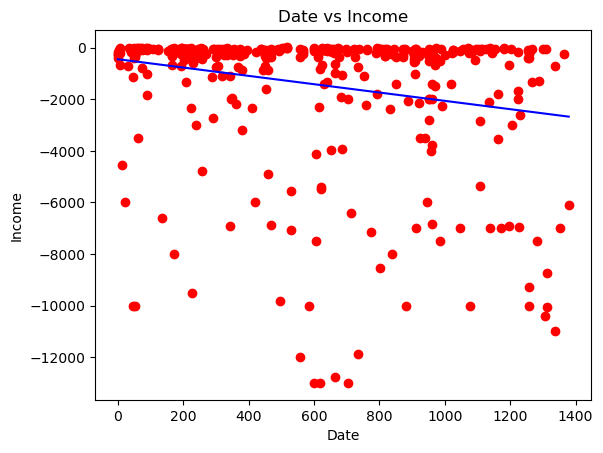

In [ ]:
y_pred = regressor.predict(X)

import matplotlib.pyplot as plt
plt.scatter(X, y, color='red')
plt.plot(X, regressor.predict(X), color='blue')
plt.title('Date vs Income')
plt.xlabel('Date')
plt.ylabel('Income')
plt.show()

Feil her også

forbrukets ODE

In [ ]:
forbruk['Brukt'] = forbruk['Brukt'].abs()
forbruk = forbruk.groupby('Dato')['Brukt'].sum().reset_index()

forbruk

,Dato,Brukt
0,2020-01-02,814.10
1,2020-01-03,250.00
2,2020-01-06,105.50
3,2020-01-09,921.94
4,2020-01-15,4551.55
...,...,...
255,2023-08-30,11000.00
256,2023-08-31,700.00
257,2023-09-14,6982.50
258,2023-09-28,229.00


In [ ]:
def forbruk_model(t, forbruk, inntekt, faste_utgifter, k1, k2):
   d_forbruk_dt = k1 * (inntekt - faste_utgifter) - k2 * forbruk
   return d_forbruk_dt

In [ ]:
from scipy.integrate import odeint

forbruk = forbruk.sort_values('Dato')
start_date = forbruk['Dato'].min()
end_date = forbruk['Dato'].max()
t = pd.date_range(start_date, end_date)

# Define the initial conditions and parameters
initial_conditions = F0
parameters = [k1, k2]

# Solve the ODE
solution = odeint(forbruk_model, initial_conditions, t, args=(inntekt, faste_utgifter, *parameters))


UFuncTypeError: Cannot cast ufunc 'greater_equal' input 0 from dtype('<m8[ns]') to dtype('<m8') with casting rule 'same_kind'

In [ ]:
import matplotlib.pyplot as plt

plt.plot(t, solution)
plt.xlabel('Time')
plt.ylabel('Forbruk')
plt.show()

HIT

In [ ]:
def stryingsrente(t, interest_rate, inflation_rate, target_inflation):
    # Define how the interest rate changes based on inflation
    if inflation_rate == target_inflation:
        return 0
    elif inflation_rate > target_inflation:
        return 0.0025  # Increase by 0.25% if inflation is above target
    else:
        return -0.0025  # Decrease by 0.25% if inflation is below target

In [ ]:
def inflasjon(t, inflation, economic_factors, target_rate):
    adjustment = k4 * (economic_factors - target_rate)
    return adjustment

## Ønsket lån

In [ ]:
startKapital = 0    # startkapitalen
terminer = 300      # 12 terminer over 25 år

Serielån

Annuitetslån

In [ ]:
initial_conditions = [I0, F0]  # Initielle betingelser
sol = solve_ivp(inntekt, t_span, initial_conditions, args=(k1, k2))

TypeError: Inntekt() takes 2 positional arguments but 4 were given